In [1]:
from StackGP import *
import sympy as sym
import pandas as pd
import numpy as np

In [2]:
data=pd.read_csv('/Users/nathanhaut/Downloads/pmlb/datasets/195_auto_price/195_auto_price.csv')

In [3]:
trainSize=np.floor(len(data)*0.7)
testSize=len(data)-trainSize

In [4]:
# Compute Hess
def ComputeSymbolicHess(model,vars):
    printedModel=sym.simplify(printGPModel(model))
    if type(printedModel)==float:
        return sym.matrices.dense.MutableDenseMatrix(np.zeros((vars,vars)))
    hess=sym.hessian(printedModel, [symbols('x'+str(i)) for i in range(vars)])
    return hess

def EvaluateHess(hess,vars,values):
    numHess=hess.subs({symbols('x'+str(j)):values[j] for j in range(vars)})
    hessN = np.array(numHess).astype(float)
    rankN=np.linalg.matrix_rank(hessN,tol=0.0001*0.0001*10)
    return rankN

def Approx2Deriv(model,values,diff1,diff2,positions): #maybe diff should be relative to the variation of each feature
    term1=[values[i]+diff1 if i == positions[0] else values[i] for i in range(len(values))]
    term1=[term1[i]+diff2 if i == positions[1] else term1[i] for i in range(len(term1))]
    term2=[values[i]-diff1 if i == positions[0] else values[i] for i in range(len(values))]
    term2=[term2[i]+diff2 if i == positions[1] else term2[i] for i in range(len(term2))]
    term3=[values[i]+diff1 if i == positions[0] else values[i] for i in range(len(values))]
    term3=[term3[i]-diff2 if i == positions[1] else term3[i] for i in range(len(term3))]
    term4=[values[i]-diff1 if i == positions[0] else values[i] for i in range(len(values))]
    term4=[term4[i]-diff2 if i == positions[1] else term4[i] for i in range(len(term4))]
    return ((evaluateGPModel(model,term1)-evaluateGPModel(model,term2))/((2*diff1))
            -(evaluateGPModel(model,term3)-evaluateGPModel(model,term4))/((2*diff1)))/(2*diff2)

def ApproxHessRank(model,vars,values,diff1=0.001,diff2=0.001):
    hess=[[Approx2Deriv(model,values,diff1,diff2,[i,j]) for i in range(vars)] for j in range(vars)]
    hessN = np.array(hess).astype(float)
    rankN=np.linalg.matrix_rank(hessN,tol=0.0001*0.0001*10)
    return rankN

def ApproxHess(model,vars,values,diff1=0.001,diff2=0.001):
    try:
        hess=[[Approx2Deriv(model,values,diff1,diff2,[i,j]) for i in range(vars)] for j in range(vars)]
    except:
        return np.zeros((vars,vars)).astype(float)
    hessN = np.array(hess).astype(float)
    return hessN

#def HessRank(model,vars,values):
#    try: 
#        with time_limit(.01):
#            hess=ComputeSymbolicHess(model,vars)
#            hess = EvaluateHess(hess,vars,values)
#            #print(hess)
#            return hess
#    except TimeoutException as e:
#        hess=ApproxHessRank(model,vars,values)
        #print(hess)
#        return hess

def HessRank(model,vars,values):
    hess=ApproxHessRank(model,vars,values)
    return hess





# Counts basis terms in a model
def count_basis_terms(equation, expand=False):
    try:
        with time_limit(2):


            if expand:
                # Simplify the equation to standardize the expression
                simplified_eq = simplify(equation)
                # Expand the expression to identify additive terms clearly
                expanded_eq = expand(simplified_eq)
            
                # Separate the terms of the expression
                terms = expanded_eq.as_ordered_terms()
            else:
                terms = equation.as_ordered_terms()
            #print(terms)
            
    except TimeoutException as e:
        return 1000
    return len(terms)

# Determines the number of basis functions in a model by counting +s and -s
def basisFunctionComplexity(model,vars, values,*args):
    try: # values should be max, min, and median with respect to response variable
        return HessRank(model,vars,values)#count_basis_terms(printGPModel(model))
    except:
        return 1000
    
def helperRank(model,vars,low,mid,high):
    try:
        return np.linalg.matrix_rank(ApproxHess(model,vars,low)+ApproxHess(model,vars,mid)+ApproxHess(model,vars,high),tol=0.0001*0.0001*10)
    except:
        return 1000

# Creates a lambda function to be used as a complexity metric when given a target dimensionality and deviation
def basisFunctionComplexityDiff(target, deviation, vars, low, mid, high):
    return lambda model,*args: max(helperRank(model,vars,low,mid,high)-target,(deviation))-deviation


In [5]:
import numpy as np

def Approx2Deriv2(model, values, diff1, diff2, positions):
    values = np.array(values)  

    term1 = values.copy()
    term1[positions[0]] += diff1
    term1[positions[1]] += diff2

    term2 = values.copy()
    term2[positions[0]] -= diff1
    term2[positions[1]] += diff2

    term3 = values.copy()
    term3[positions[0]] += diff1
    term3[positions[1]] -= diff2

    term4 = values.copy()
    term4[positions[0]] -= diff1
    term4[positions[1]] -= diff2

    f1, f2, f3, f4 = map(lambda x: evaluateGPModel(model, x), [term1, term2, term3, term4])

    return ((f1 - f2) / (2 * diff1) - (f3 - f4) / (2 * diff1)) / (2 * diff2)

def ApproxHessRank2(model, vars, values, diff1=0.001, diff2=0.001):
    usedVars=[j(range(vars)) for j in model[1] if callable(j)]
    hess = np.array([[Approx2Deriv2(model, values, diff1, diff2, [i, j]) for i in usedVars] for j in usedVars], dtype=float)
    rankN = np.linalg.matrix_rank(hess, tol=1e-8)  
    return rankN

def ApproxHess2(model,vars,values,diff1=0.001,diff2=0.001):
    try:
        usedVars=[j(range(vars)) for j in model[1] if callable(j)]
        hess=[[Approx2Deriv2(model,values,diff1,diff2,[i,j]) for i in usedVars] for j in usedVars]
    except:
        usedVars=[j(range(vars)) for j in model[0][1] if callable(j)]
        return np.zeros((len(usedVars),len(usedVars))).astype(float)
    hessN = np.array(hess).astype(float)
    return hessN

def helperRank2(model,vars,low,mid,high):
    try:
        return np.linalg.matrix_rank(ApproxHess2(model,vars,low)+ApproxHess2(model,vars,mid)+ApproxHess2(model,vars,high),tol=0.0001*0.0001*10)
    except:
        return 1000
    
import sympy as sp

def symbolic_hessian(model, vars):
    """
    Computes the symbolic Hessian matrix of function f with respect to variables vars.
    
    Parameters:
        f (sympy expression): The function to differentiate.
        vars (list of sympy symbols): Variables with respect to which Hessian is computed.
    
    Returns:
        sympy.Matrix: Hessian matrix
    """
    f = sym.simplify(printGPModel(model))
    usedVars=[j(range(vars)) for j in model[1] if callable(j)]
    varSyms=[symbols('x'+str(i)) for i in usedVars]
    #varSyms=sp.symbols(f'x0:{vars}') 
    #hessian_matrix = sp.Matrix([[sp.diff(sp.diff(f, vi), vj) for vj in varSyms] for vi in varSyms])
    hessian_matrix = sp.hessian(f, varSyms)
    return hessian_matrix

def ComputeSymbolicHess(model,vars):
    printedModel=sym.simplify(printGPModel(model))
    usedVars=[j(range(vars)) for j in model[1] if callable(j)]
    if type(printedModel)==float:
        return sym.matrices.dense.MutableDenseMatrix(np.zeros((len(usedVars),len(usedVars))))
    hess=sym.hessian(printedModel, varSyms=[symbols('x'+str(i)) for i in usedVars])
    return hess

def symbolic_hessian_wrapper(model,vars, values=None):
    """
    Computes the symbolic Hessian matrix of a function and optionally evaluates it at given values.

    Parameters:
        f_expr (sympy expression): The function to differentiate.
        var_symbols (list of sympy symbols): List of variables in the function.
        values (dict, optional): Dictionary mapping each variable to a numeric value.

    Returns:
        sympy.Matrix: If `values` is None, returns the symbolic Hessian matrix.
        numpy.ndarray: If `values` is provided, returns the evaluated Hessian as a NumPy array.
    """
    # Compute the symbolic Hessian matrix
    hessian_matrix = symbolic_hessian(model, vars)
    
    if values is None:
        return hessian_matrix  # Return symbolic Hessian if no values are provided

    values_dict = dict(zip([symbols('x'+str(i)) for i in range(vars)], values))

    # Substitute values and convert to NumPy array
    hessian_numeric = hessian_matrix.subs(values_dict).evalf()
    return sp.matrix2numpy(hessian_numeric, dtype=float)

def symbolic_hessian_full(model,vars, minVal,maxVal,meanVal):
    """
    Computes the symbolic Hessian matrix of a function and optionally evaluates it at given values.

    Parameters:
        f_expr (sympy expression): The function to differentiate.
        var_symbols (list of sympy symbols): List of variables in the function.
        values (dict, optional): Dictionary mapping each variable to a numeric value.

    Returns:
        sympy.Matrix: If `values` is None, returns the symbolic Hessian matrix.
        numpy.ndarray: If `values` is provided, returns the evaluated Hessian as a NumPy array.
    """
    # Compute the symbolic Hessian matrix
    hessian_matrix = symbolic_hessian(model, vars)
    

    valuesMin_dict = dict(zip([symbols('x'+str(i)) for i in range(vars)], minVal))
    valuesMax_dict = dict(zip([symbols('x'+str(i)) for i in range(vars)], maxVal))
    valuesMean_dict = dict(zip([symbols('x'+str(i)) for i in range(vars)], meanVal))

    # Substitute values and convert to NumPy array
    hessian_numeric = hessian_matrix.subs(valuesMin_dict).evalf()+hessian_matrix.subs(valuesMax_dict).evalf()+hessian_matrix.subs(valuesMean_dict).evalf()
    return sp.matrix2numpy(hessian_numeric, dtype=float)

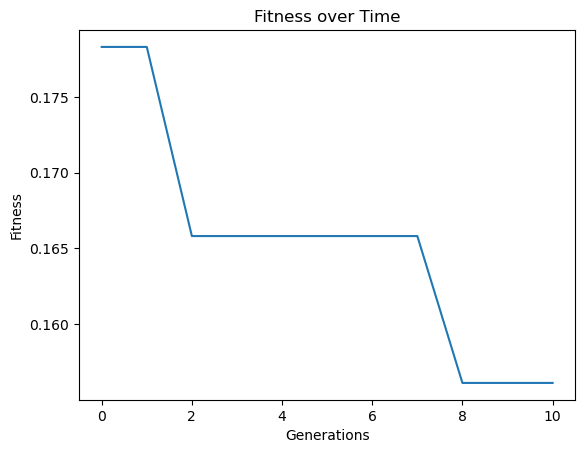

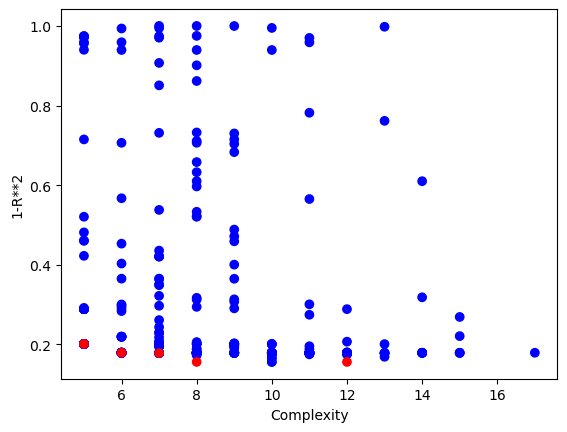

In [6]:
models=evolve(np.array(data.iloc[:,:-1].T),np.array(data.iloc[:,-1]),generations=10,tracking=True)
plotModels(models)

# Reference points

In [7]:
minPos=np.argmin(data.iloc[:,-1])
maxPos=np.argmax(data.iloc[:,-1])
meanPos=np.argmin(np.abs(data.iloc[:,-1]-np.mean(data.iloc[:,-1])))


# Runtime comparisons

In [8]:
len(models)

312

In [9]:
hessians=[ApproxHess(mod,15,data.iloc[minPos])+ApproxHess(mod,15,data.iloc[maxPos])+ApproxHess(mod,15,data.iloc[meanPos]) for mod in models]

In [10]:
hessians2=[ApproxHess2(mod,15,data.iloc[minPos])+ApproxHess2(mod,15,data.iloc[maxPos])+ApproxHess2(mod,15,data.iloc[meanPos]) for mod in models]

In [11]:
hessians3=[symbolic_hessian_full(mod,15,data.iloc[minPos],data.iloc[maxPos],data.iloc[meanPos]) for mod in models]

# Rank comparison

In [73]:
vars=[]
num1=[]
num2=[]
symbolic=[]
for i in range(len(models)):
    #print(printGPModel(models[i]))
    vars.append(len([j(range(15)) for j in models[i][1] if callable(j)]))
    num1.append(np.linalg.matrix_rank(hessians[i]))
    num2.append(np.linalg.matrix_rank(hessians2[i],tol=1e-5))
    symbolic.append(np.linalg.matrix_rank(hessians3[i]))


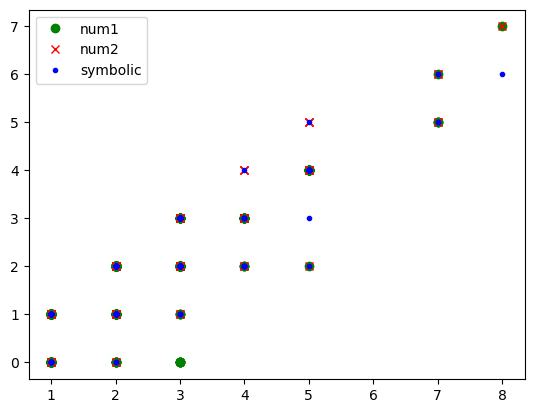

In [69]:
# Plot the results {vars, num1, num2, symbolic}
import matplotlib.pyplot as plt
plt.plot(vars,symbolic,'go')
plt.plot(vars,num1,'rx')
plt.plot(vars,num2,'b.')

plt.legend(['num1','num2','symbolic'])
plt.show()



In [63]:
np.array(symbolic)-np.array(num1)

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1, -1, -1,  0,  0, -1, -1, -1, -1,  0,  0, -1, -1,
        0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1, -1, -1, -1, -1,  0,  0, -1, -1, -1, -1, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -3,  0,  0,  1, -2, -2,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  0, -1, -1, -1, -1, -3, -2, -2, -2,  0, -1,  0,  0,
       -1,  0,  0, -1, -2,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,
       -1, -1,  0,  0,  0

In [64]:
np.array(vars)-np.array(num2)

array([0, 1, 1, 1, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 2])

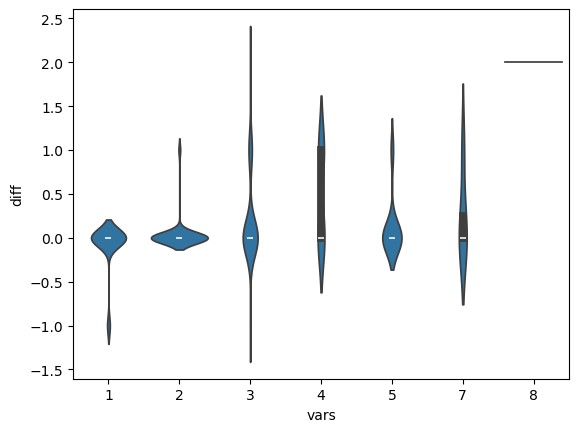

In [74]:
# Plot violin plot of the results {diff = symbolic - num1}
import seaborn as sns
df = pd.DataFrame({'vars': vars, 'diff': np.array(symbolic)-np.array(num2)})
sns.violinplot(x='vars', y='diff', data=df)
plt.show()


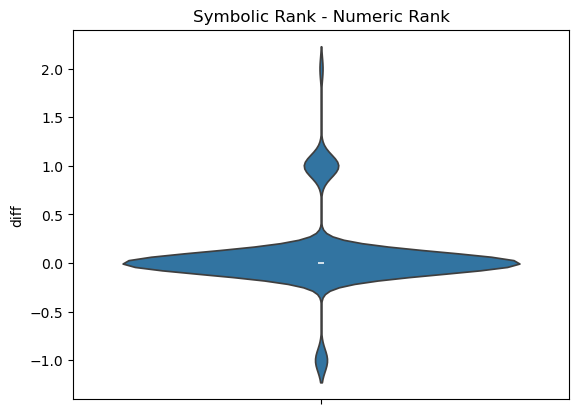

In [75]:
import seaborn as sns
df = pd.DataFrame({'diff': np.array(symbolic)-np.array(num2)})
sns.violinplot( y='diff', data=df)
plt.title('Symbolic Rank - Numeric Rank')
plt.show()

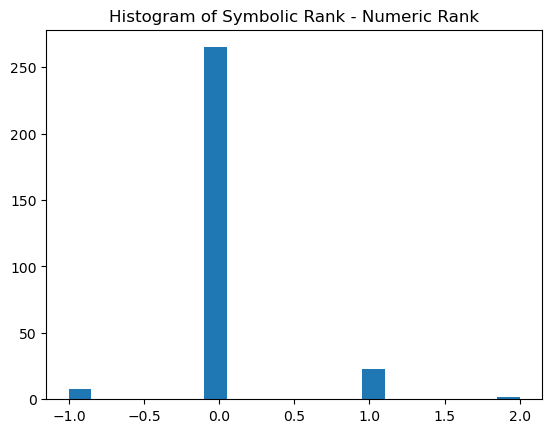

In [76]:
# Histogram of differences
plt.hist(np.array(symbolic)-np.array(num2), bins=20)    
plt.title('Histogram of Symbolic Rank - Numeric Rank')
plt.show()
